<a href="https://colab.research.google.com/github/marc1971/Assignement-Module4-CAS-NLP/blob/main/final_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

### Connecting to HuggingFace

In [1]:
from huggingface_hub import notebook_login

notebook_login()

### Connecting to GoogleDrive

In [2]:
# Connecting to Google Drive to get access to data, that is used for training the model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Necessary imports

In [5]:
!pip install -q -U torch==2.1.0 datasets transformers tensorflow langchain playwright html2text sentence_transformers faiss-cpu
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7 typing-extensions==4.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.7/806.7 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.5/238.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

### Dependencies

In [3]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)
from datasets import load_dataset
from peft import LoraConfig, PeftModel

from langchain.text_splitter import CharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


### Load quantized Mistal 7B

In [5]:
#################################################################
# Tokenizer
#################################################################

model_name='mistralai/Mistral-7B-Instruct-v0.1'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Count number of trainable parameters

In [6]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 262410240
all model parameters: 3752071168
percentage of trainable model parameters: 6.99%


### Build Mistral text generation pipeline

In [7]:
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    do_sample = True,
    max_new_tokens=1000,
)

In [8]:
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

### Load and chunk documents. Load chunked documents into FAISS index

In [ ]:
!playwright install
!playwright install-deps

152.8 MiB [] 0% 0.0s152.8 MiB [] 0% 44.3s152.8 MiB [] 0% 16.6s152.8 MiB [] 0% 14.9s152.8 MiB [] 0% 12.5s152.8 MiB [] 0% 11.8s152.8 MiB [] 1% 10.5s152.8 MiB [] 1% 9.0s152.8 MiB [] 1% 8.3s152.8 MiB [] 1% 8.2s152.8 MiB [] 2% 8.1s152.8 MiB [] 2% 7.9s152.8 MiB [] 2% 8.2s152.8 MiB [] 3% 8.0s152.8 MiB [] 3% 7.6s152.8 MiB [] 3% 7.5s152.8 MiB [] 4% 7.4s152.8 MiB [] 4% 7.3s152.8 MiB [] 4% 7.2s152.8 MiB [] 5% 6.9s152.8 MiB [] 5% 6.7s152.8 MiB [] 6% 6.5s152.8 MiB [] 6% 6.4s152.8 MiB [] 6% 6.6s152.8 MiB [] 6% 6.8s152.8 MiB [] 7% 6.3s152.8 MiB [] 7% 6.1s152.8 MiB [] 8% 5.8s152.8 MiB [] 8% 5.7s152.8 MiB [] 9% 5.8s152.8 MiB [] 9% 6.0s152.8 MiB [] 9% 5.9s152.8 MiB [] 9% 6.1s152.8 MiB [] 10% 6.0s152.8 MiB [] 10% 5.9s152.8 MiB [] 11% 5.9s152.8 MiB [] 11% 5.8s152.8 MiB [] 12% 5.7s152.8 MiB [] 13% 5.6s152.8 MiB [] 13% 5.5s152.8 MiB [] 14% 5.5s152.8 MiB [] 14% 5.4s152.8 MiB [] 15% 5.4s152.8 MiB [] 16% 5.2s152.8 MiB [] 17% 5.1s152.8 MiB [] 17% 5.0s152.8 MiB [] 18% 4.9s152.8 MiB [] 19% 4.8s152.8 MiB [] 19% 4.

## Loading Text Documents

The source of the text is different documents stored on Googledrive. There are actually 37 Documents with different number of characters.

In [5]:
from text_loader import load_text


In [6]:
dict_path = '/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/Textdata/'
texts = load_text(dict_path, 'all')

In [7]:
len(texts)

37

In [8]:
print('Number of Documents: ',len(texts))
print('Nummer of Characters of the different Documents:', [len(texts[i]) for i in range(len(texts))])

Number of Documents:  37
Nummer of Characters of the different Documents: [1291, 15135, 7178, 12476, 30276, 24598, 24632, 4698, 2461, 2959, 23690, 18321, 16531, 10850, 4443, 2594, 18649, 11961, 12707, 29260, 6103, 32785, 4467, 2033, 2133, 32903, 21596, 3254, 24021, 24021, 21734, 6340, 4346, 17057, 32809, 13281, 9545]


In [9]:
#Example of Document
texts[0]

'Reglement über die Aufgaben und Befugnisse der Vizerektorin oder des Vizerektors vom 20. Juni 2023.\nDer Rektor der Pädagogischen Hochschule, gestützt auf Artikel 10 Absatz 2 und Artikel 39 Absatz 1 Buchstabe n des Gesetzes vom 8. September 2004 über die deutschsprachige Pädagogische Hochschule (PHG)1 sowie in Ausführung von Artikel 3 Absatz 6 des Statuts der deutschsprachigen Pädagogischen Hochschule vom 12. Juni 2018 (PHSt)2, beschliesst: Dieses Reglement regelt die Zuweisung von Aufgaben der Rektorin oder des Rektors der Pädagogischen Hochschule an die Vizerektorin oder den Vizerektor sowie deren oder dessen Vertretungsbefugnis. Die Vizerektorin oder der Vizerektor hat während längerer Abwesenheiten der Rektorin oder des Rektors sämtliche Kompetenzen der- oder desselben inne, leitet das Programm «Strategisches Hochschulprozessmanagement», ist zuständig für die Bereichsleitungskonferenzen, kann die Rektorin oder den Rektor an Anlässen vertreten. Entscheidungen von grösserer Tragweit

## Text Analysis

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
text_all = " ".join([str(text) for text in texts])
len(text_all)

533174

Häufigstes Vorkommen:  3213 mal
2729 Wörter kommen nur 1-mal vor im Text.


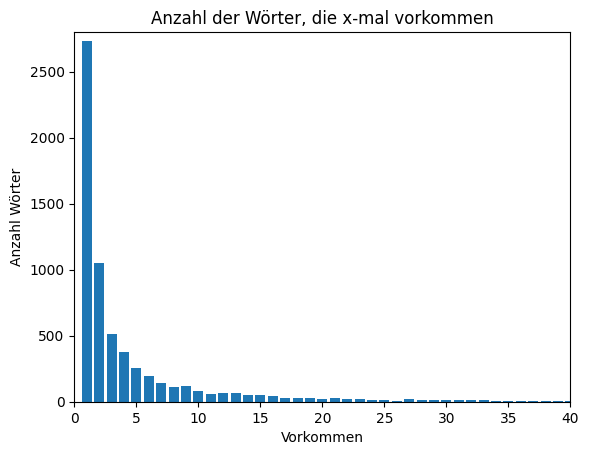

In [102]:
from collections import Counter
import re


# Normalize the text to lowercase and remove non-alphanumeric characters
words = re.findall(r'\b\w+\b', text_all.lower())

# Count the words
word_counts = Counter(words)
counts = list(word_counts.values())
counts.sort()
c_counts = Counter(counts)

vorkommen = list(c_counts.keys())
anzahl = list(c_counts.items())
y = [tup[1] for tup in anzahl]

print('Häufigstes Vorkommen: ', max(vorkommen), 'mal')
print(max(y), 'Wörter kommen nur 1-mal vor im Text.')


plt.bar(vorkommen, y)
plt.title('Anzahl der Wörter, die x-mal vorkommen')
plt.xlim(0,40)
plt.ylim(0,2800)
plt.xlabel('Vorkommen')
plt.ylabel('Anzahl Wörter')
plt.show()

In [12]:
#Unique Words count

unique_words = set(words)  # 'words' from the previous example
print(f"Number of unique words: {len(unique_words)}")

Number of unique words: 6490


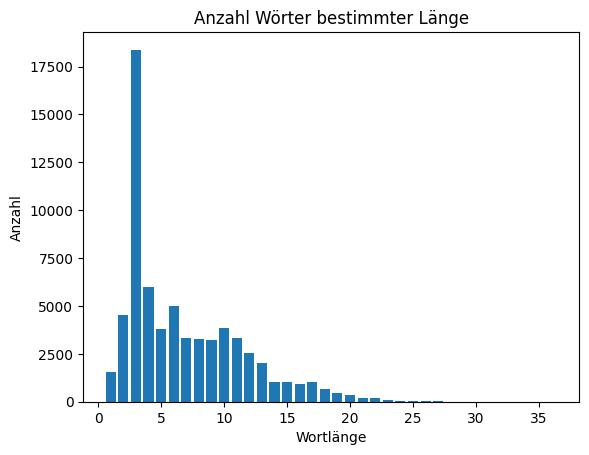

In [30]:
word_lengths = [len(word) for word in words]
length_counts = Counter(word_lengths)

# Display the count of each word length
w_length = []
w_count = []
for length, count in sorted(length_counts.items()):
    w_length.append(length)
    w_count.append(count)
    #print(f"Length {length}: {count} times")

plt.bar(w_length, w_count)
plt.title('Anzahl Wörter bestimmter Länge')
plt.xlabel('Wortlänge')
plt.ylabel('Anzahl')
plt.show()

In [15]:
!pip install textstat
import textstat

readability_score = textstat.flesch_reading_ease(text_all)
print(f"Flesch Reading Ease: {readability_score}")

Flesch Reading Ease: 38.11


In [16]:
from nltk.util import ngrams

bigrams = ngrams(words, 2)
bigram_counts = Counter(bigrams)

# Display the 5 most common bigrams
print(bigram_counts.most_common(5))

[(('für', 'die'), 260), (('die', 'studierenden'), 254), (('in', 'der'), 223), (('über', 'die'), 222), (('pädagogischen', 'hochschule'), 212)]


## Split the Text in Chunks

### 1. Set up the CharacterTextSplitter to split then the Text in Chunks.

In [15]:
from text_loader import text_splitting

In [16]:
from langchain.text_splitter import CharacterTextSplitter
chunk_size = 500
overlap = 0

text_splitter = text_splitting(chunk_size, overlap, separator="")

### 2. Writing out the first line of each document, since it is the title of the document.

In [17]:
from text_loader import get_text_before_newline

### 3. Creating a LangChain-Document

The Document *'documents'* is a list of LangChain-Objects, created with the help of the *'create_documents'*-methode of the TextSplitter that containes dicionaries with the keys *'page_content'* and *'metadata'*.

In [18]:
from text_loader import create_LangChain_doc

In [19]:
documents = create_LangChain_doc(texts, chunk_size, overlap, separator="")

In [21]:
len(documents)

1086

In [20]:
documents[10]

Document(page_content='und organisatorische Massnahmen gemäss den Artikeln 4 bis 6 der Datenschutzverordnung vom 22. Oktober 2008 zu schützen. Der Rechtsdienst erarbeitet hierzu eine Checkliste. Personendaten werden grundsätzlich nur bei den betroffenen Personen bzw. deren gesetzlichen Vertreterinnen und Vertretern beschafft. Bei systematischen Erhebungen muss die Rechtsgrundlage und der Zweck der Beschaffung angegeben sowie, falls keine Auskunftspflicht besteht, auf die Freiwilligkeit der Auskunft hingewiesen werden.', metadata={'document': 'Weisungen über den Umgang mit Personendaten (Datenschutzweisungen) vom 29. Juni 2021.'})

In [22]:
print(type(documents[1]))
print(len(documents[1].page_content))
print(documents[7].page_content)
print(documents[1].metadata)

<class 'langchain_core.documents.base.Document'>
499
schutzrecht verstösst; Mitarbeiterinnen und Mitarbeiter: Mitarbeiterinnen und Mitarbeiter der Pädagogischen Hochschule gemäss Artikel 11 Absatz 2 PHG. Die Mitarbeiterinnen und Mitarbeiter bearbeiten Personendaten nur, wenn und soweit sie durch Gesetz oder Verordnung dazu ermächtigt werden oder b dies für die Erfüllung ihrer dienstrechtlichen Verpflichtungen gegenüber der Pädagogischen Hochschule erforderlich ist. Die Mitarbeiterinnen und Mitarbeiter bearbeiten besonders schützenswerte Personenda
{'document': 'Reglement über die Aufgaben und Befugnisse der Vizerektorin oder des Vizerektors vom 20. Juni 2023.'}


As expected the length of the content in each entry is 500 (499) characters. (no idea why 499???)

### 4. Splitting the LangChain-Document in Chunks

Now we have to make a List of all Document-Entries. It can be done with the *'split_documents'*-methode.

In [23]:
from text_loader import chunk_docs

In [24]:
chunked_documents = chunk_docs(documents,chunk_size, overlap, separator="")

In [25]:
print(len(chunked_documents))

1086


## Creating a Vector-Database and building a Retriever

In [26]:
# Load chunked documents into the FAISS index
db = FAISS.from_documents(chunked_documents,
                          HuggingFaceEmbeddings(model_name='PM-AI/bi-encoder_msmarco_bert-base_german'))

# Connect query to FAISS index using a retriever

retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 4}
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/729k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Create PromptTemplate and LLMChain

In [27]:
prompt_template = """
### [INST] Instruction: Answer the question based on your
knowledge about PHBern. Answer in german! Here is context to help:

{context}

### QUESTION:
{question} [/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain by pasting together the Text_generation-Pipeline 'mistral_lmm' and the prompt
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

In [28]:
llm_chain.invoke({"context": "", "question": "Wie lange werden meine Arbeitszeugnisse an der PHBern aufbewahrt?"})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'context': '',
 'question': 'Wie lange werden meine Arbeitszeugnisse an der PHBern aufbewahrt?',
 'text': ' Die Dauer, für die Arbeitszeugnisse an der PHBern aufbewahrt werden, wird von der Schweizerischen Bundesbehörde für Arbeit und Sozialversicherungen (BA) bestimmt. Nach Art. 10 Abs. 2 des Bundesgesetzes über die Arbeitsschutzversicherung (ASVG) werden Arbeitszeugnisse für eine Dauer von zehn Jahren aufbewahrt. Danach können sie vom Inhaber nach eigenem Wunsch gelöst oder von der BA angefordert werden.'}

### Build RAG Chain

The RAG Chain finally is the all glued together: the Generator-Pipeline *'mistral_lmm'*, the *PromptTemplate* (prompt), augmented by an external context, found by the *retriever*!

In [47]:
rag_chain = ( {"context": retriever, "question": RunnablePassthrough()} | llm_chain )

result = rag_chain.invoke("Wie viele ECTS-Punkte umfasst das Masterstudium Sek I?")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [48]:
result['context']

[Document(page_content='der Institutsleiter Auflagen im Umfang von insgesamt maximal 60 ECTS-Punkten festlegen. Zum Masterstudium S1 für Personen mit einem fachwissenschaftlichen Hochschulabschluss wird zugelassen, wer mindestens über einen Bachelor- oder gleichwertigen Zwischenabschluss einer Universität oder Fachhochschule mit mindestens 90 ECTS-Punkten in einem stufenrelevanten Unterrichtsfach verfügt. Zur Gewährleistung der Gleichwertigkeit mit dem Bachelor- und Masterstudium S1 kann die Institutsleiterin oder der', metadata={'document': 'Allgemeine Zulassungsweisungen vom 20. Juni 2023.'}),
 Document(page_content='bei ist sicherzustellen, dass die zentralen Inhaltsgebiete dessen abgedeckt sind, was auf der Sekundarstufe I im betreffenden Fach oder Fachbereich unterrichtet wird. Um zum Masterstudium Sekundarstufe I für Personen mit einem fachwissenschaftlichen Hochschulabschluss zugelassen zu werden, bedarf es mit Blick auf den ersten Fachbereich mindestens eines Bachelor- oder gle

In [49]:
print(result['text'])


Das Masterstudium Sekundarstufe I umfasst insgesamt maximal 75 ECTS-Punkte.
